In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [2]:


from data.dataset import AIGCodeSet



/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# Load AIGCodeSet dataset
dataset_loader = AIGCodeSet('../../data/')
train, val, test = dataset_loader.get_dataset(split=True)


from datasets import concatenate_datasets


# Combine all splits for node type extraction
aigcodeset = concatenate_datasets([train, val, test])



In [4]:

# Setup Tree-sitter parsers for different languages
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)


import matplotlib.pyplot as plt


Total samples in AIGCodeSet: 7583
Features available: ['code', 'target']
Sample data: {'code': "import sys\n\ndef main():\n\n    # sys.stdin = open('input156b.txt')\n\n    n, k = map(int, input().split())\n\n    ans = 1\n    m = k\n    while n >= m:\n        m *= k\n        ans += 1\n\n    print(ans)\nif __name__ == '__main__':\n    main()", 'target': 1}


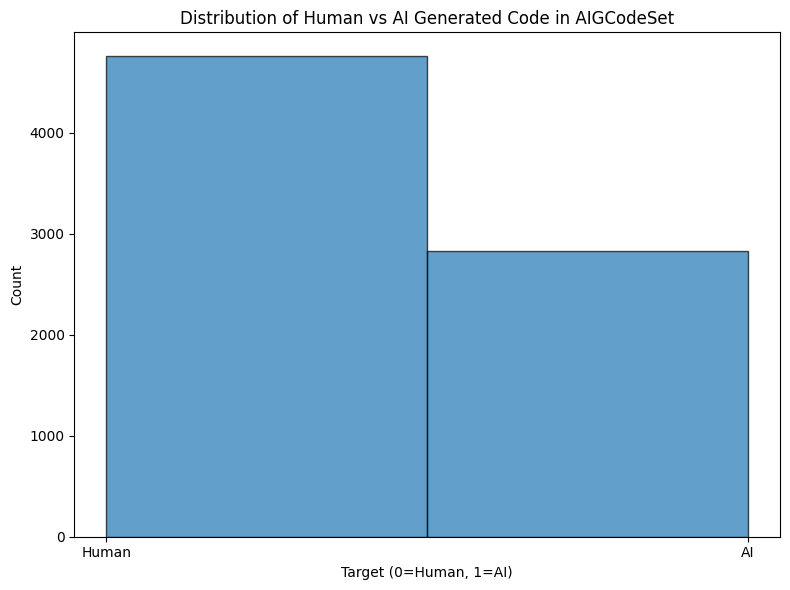

Human-generated code samples: 4755
AI-generated code samples: 2828
Total samples: 7583


In [5]:


# Analyze the dataset structure first
print(f"Total samples in AIGCodeSet: {len(aigcodeset)}")
print(f"Features available: {list(aigcodeset.features.keys())}")
print(f"Sample data: {aigcodeset[0]}")


# Check target distribution
target_counts = aigcodeset['target']
plt.figure(figsize=(8, 6))
plt.hist(target_counts, bins=2, edgecolor='black', alpha=0.7)
plt.xlabel('Target (0=Human, 1=AI)')
plt.ylabel('Count')
plt.title('Distribution of Human vs AI Generated Code in AIGCodeSet')
plt.xticks([0, 1], ['Human', 'AI'])
plt.tight_layout()
plt.show()

human_count = target_counts.count(0)
ai_count = target_counts.count(1)

print(f'Human-generated code samples: {human_count}')
print(f'AI-generated code samples: {ai_count}')
print(f'Total samples: {human_count + ai_count}')


In [6]:


# Analyze code languages by examining file extensions or content patterns
import re

def detect_language(code):
    # """Simple language detection based on code patterns"""
    # code_lower = code.lower()
    
    # # Python indicators
    # if any(pattern in code for pattern in ['def ', 'import ', 'if __name__', 'print(', 'range(']):
    #     return 'python'
    
    # # Java indicators  
    # if any(pattern in code for pattern in ['public class', 'System.out', 'public static void main', '//']) and '{' in code:
    #     return 'java'
    
    # # C++ indicators
    # if any(pattern in code for pattern in ['#include', 'std::', 'cout', 'cin', 'using namespace']):
    #     return 'cpp'
    
    # # Default to Python if unclear (since AIGCodeSet is primarily Python)
    return 'python'


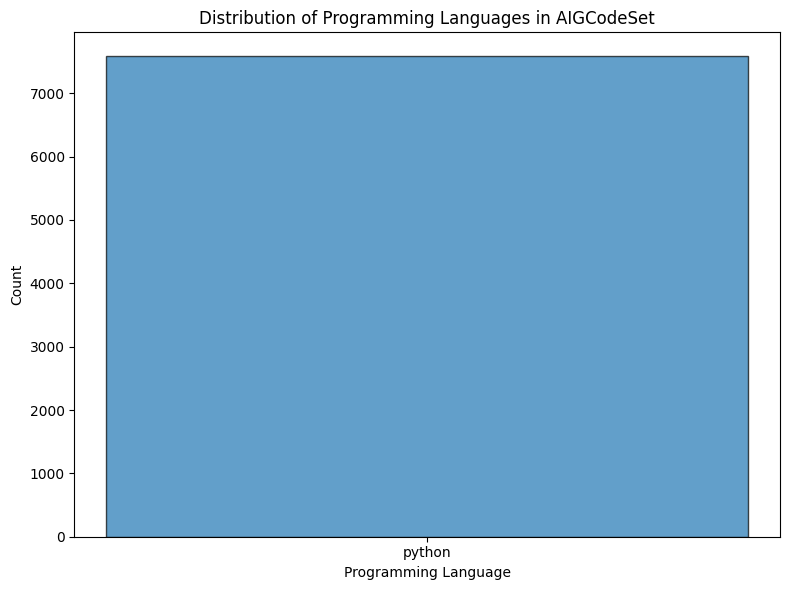

In [7]:

# Detect languages in the dataset
languages = [detect_language(sample['code']) for sample in aigcodeset]

# Plot language distribution
plt.figure(figsize=(8, 6))
language_counts = {}
for lang in languages:
    language_counts[lang] = language_counts.get(lang, 0) + 1

plt.bar(language_counts.keys(), language_counts.values(), edgecolor='black', alpha=0.7)
plt.xlabel('Programming Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in AIGCodeSet')
plt.tight_layout()
plt.show()


In [8]:

for lang, count in language_counts.items():
    print(f'{lang.capitalize()} samples: {count}')


Python samples: 7583


In [9]:


def get_parser(language):
    """Get the appropriate Tree-sitter parser for a given language"""
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")


In [10]:


def create_tree(sample, code_key='code'):
    """Create AST tree from code sample"""
    # For AIGCodeSet, we need to detect language since it's not explicitly provided
    language = detect_language(sample[code_key])
    parser = get_parser(language)
    code_bytes = bytes(sample[code_key], 'utf-8')
    tree = parser.parse(code_bytes)
    return tree, language


In [11]:


from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    """Walk through the AST and print structure"""
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()


In [12]:


from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    """Extract all node types from AST"""
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types



In [13]:

def extract_types(sample):
    """Extract node types from a code sample"""
    # Import everything needed inside the function for multiprocessing
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    import re
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def detect_language(code):
        """Simple language detection based on code patterns"""
        # code_lower = code.lower()
        
        # # Python indicators
        # if any(pattern in code for pattern in ['def ', 'import ', 'if __name__', 'print(', 'range(']):
        #     return 'python'
        
        # # Java indicators  
        # if any(pattern in code for pattern in ['public class', 'System.out', 'public static void main', '//']) and '{' in code:
        #     return 'java'
        
        # # C++ indicators
        # if any(pattern in code for pattern in ['#include', 'std::', 'cout', 'cin', 'using namespace']):
        #     return 'cpp'
        
        # # Default to Python if unclear
        return 'python'
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    language = detect_language(sample['code'])
    parser = get_parser(language)
    code_bytes = sample['code'].encode('utf-8')
    tree = parser.parse(code_bytes)
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types), "language": language}


In [14]:

# Extract all node types from the dataset
print("Extracting node types from AIGCodeSet...")
result = aigcodeset.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types from AIGCodeSet")


Extracting node types from AIGCodeSet...


Map (num_proc=8): 100%|██████████| 7583/7583 [00:00<00:00, 13722.15 examples/s]



Collected 178 unique node types from AIGCodeSet


In [15]:


# Sort and create mapping
all_types = sorted(list(all_types))
type_to_ind = {t: i for i, t in enumerate(all_types)}

print(f"Total unique node types: {len(all_types)}")
print("\nFirst 20 node types:")
for i, node_type in enumerate(all_types[:20]):
    print(f"{i:3d}: {node_type}")


Total unique node types: 178

First 20 node types:
  0: !=
  1: %
  2: %=
  3: &
  4: &=
  5: (
  6: )
  7: *
  8: **
  9: **=
 10: *=
 11: +
 12: +=
 13: ,
 14: -
 15: -=
 16: ->
 17: .
 18: /
 19: //


In [16]:


# Display all node types with highlighting for control-flow and comments
def is_control_flow_node(node_type):
    """Detect control-flow related nodes"""
    control_flow_patterns = [
        'if_statement', 'if_expression', 'conditional_expression', 'ternary_expression',
        'else_clause', 'elif_clause', 'else_statement',
        'for_statement', 'while_statement', 'do_statement', 'for_in_statement',
        'enhanced_for_statement', 'for_each_statement',
        'break_statement', 'continue_statement', 'return_statement', 'goto_statement',
        'try_statement', 'catch_clause', 'finally_clause', 'throw_statement',
        'except_clause', 'raise_statement', 'with_statement',
        'switch_statement', 'switch_expression', 'case_clause', 'default_clause',
        'assert_statement', 'assertion',
        'yield_statement', 'yield_expression'
    ]
    
    node_lower = node_type.lower()
    
    if node_lower in [pattern.lower() for pattern in control_flow_patterns]:
        return True
    
    control_keywords = ['if', 'else', 'for', 'while', 'switch', 'case', 'try', 'catch', 'finally']
    
    for keyword in control_keywords:
        if (node_lower == keyword or 
            node_lower.startswith(keyword + '_') or 
            node_lower.endswith('_' + keyword) or
            (keyword + '_statement' in node_lower) or
            (keyword + '_expression' in node_lower) or
            (keyword + '_clause' in node_lower)):
            return True
    
    if any(pattern in node_lower for pattern in ['_statement', '_clause', '_expression'] if 
           any(kw in node_lower for kw in ['break', 'continue', 'return', 'goto', 'yield', 'raise', 'assert', 'throw'])):
        return True
    
    return False


In [17]:

# Categorize and display node types
control_flow_types = []
comment_types = []
other_types = []

for node_type, index in sorted(type_to_ind.items(), key=lambda x: x[1]):
    if 'comment' in node_type.lower():
        comment_types.append((node_type, index))
    elif is_control_flow_node(node_type):
        control_flow_types.append((node_type, index))
    else:
        other_types.append((node_type, index))


In [18]:

# Display with highlighting
print(f"All {len(all_types)} node types in AIGCodeSet:")
print("=" * 60)
for node_type, index in sorted(type_to_ind.items(), key=lambda x: x[1]):
    if is_control_flow_node(node_type):
        print(f"{index:3d}: {node_type} ⭐ CONTROL-FLOW")
    elif 'comment' in node_type.lower():
        print(f"{index:3d}: {node_type} 💬 COMMENT")
    else:
        print(f"{index:3d}: {node_type}")

print("=" * 60)
print(f"Control-flow types: {len(control_flow_types)}")
print(f"Comment types: {len(comment_types)}")
print(f"Other types: {len(other_types)}")


All 178 node types in AIGCodeSet:
  0: !=
  1: %
  2: %=
  3: &
  4: &=
  5: (
  6: )
  7: *
  8: **
  9: **=
 10: *=
 11: +
 12: +=
 13: ,
 14: -
 15: -=
 16: ->
 17: .
 18: /
 19: //
 20: //=
 21: /=
 22: :
 23: :=
 24: ;
 25: <
 26: <<
 27: <<=
 28: <=
 29: =
 30: ==
 31: >
 32: >=
 33: >>
 34: >>=
 35: @
 36: ERROR
 37: [
 38: \
 39: ]
 40: ^
 41: ^=
 42: aliased_import
 43: and
 44: argument_list
 45: as
 46: as_pattern
 47: as_pattern_target
 48: assert
 49: assert_statement ⭐ CONTROL-FLOW
 50: assignment
 51: attribute
 52: augmented_assignment
 53: binary_operator
 54: block
 55: boolean_operator
 56: break
 57: break_statement ⭐ CONTROL-FLOW
 58: call
 59: case ⭐ CONTROL-FLOW
 60: class
 61: class_definition
 62: comment 💬 COMMENT
 63: comparison_operator
 64: concatenated_string
 65: conditional_expression ⭐ CONTROL-FLOW
 66: constrained_type
 67: continue
 68: continue_statement ⭐ CONTROL-FLOW
 69: decorated_definition
 70: decorator
 71: def
 72: default_parameter
 73: del


In [19]:


from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    """Convert AST tree to graph representation"""
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id



In [20]:

from tqdm import tqdm

def create_graph(sample, code_key='code'):
    """Create graph representation from code sample"""
    tree, language = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    
    if not edges:  # Handle empty edge case
        edge_index = tensor([], dtype=tlong).reshape(2, 0)
    else:
        edge_index = tensor(edges, dtype=tlong).t().contiguous()
    
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target']], dtype=tlong)
    
    metadata = {
        'language': language,
        'target': sample['target'],
        'code': sample['code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index,
        metadata=metadata
    )    
    return data



In [21]:

def create_graphs(dataset, desc_keyword, code_key='code'):
    """Create graph representations for a dataset split"""
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        try:
            data = create_graph(sample, code_key)
            graphs.append(data)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            print(f"Sample code: {sample[code_key][:100]}...")
            continue

    return graphs



In [22]:

# Create and save graphs for all splits
from torch import save

print("Creating graphs for AIGCodeSet...")

train_graphs = create_graphs(train, 'train')
save(train_graphs, '../../data/aigcodeset_graphs/train_graphs.pt')
print(f"Saved {len(train_graphs)} training graphs")
del train, train_graphs

val_graphs = create_graphs(val, 'val')
save(val_graphs, '../../data/aigcodeset_graphs/val_graphs.pt')
print(f"Saved {len(val_graphs)} validation graphs")
del val, val_graphs

test_graphs = create_graphs(test, 'test')
save(test_graphs, '../../data/aigcodeset_graphs/test_graphs.pt')
print(f"Saved {len(test_graphs)} test graphs")
del test, test_graphs

# Save the node type mapping
save(type_to_ind, '../../data/aigcodeset_graphs/type_to_ind.pt')
print("Saved node type mapping")

print("\nAIGCodeSet graph creation completed!")


Creating graphs for AIGCodeSet...


Creating train graphs: 100%|██████████| 5307/5307 [00:02<00:00, 2318.08it/s]



Saved 5307 training graphs


Creating val graphs: 100%|██████████| 759/759 [00:00<00:00, 2370.91it/s]



Saved 759 validation graphs


Creating test graphs: 100%|██████████| 1517/1517 [00:00<00:00, 2198.57it/s]



Saved 1517 test graphs
Saved node type mapping

AIGCodeSet graph creation completed!


Loaded 5307 training graphs
Sample graph: Data(
  x=[92],
  edge_index=[2, 91],
  y=[1],
  metadata={
    language='python',
    target=1,
    code='import sys

def main():

    # sys.stdin = open('input156b.txt')

    n, k = map(int, input().split())

    ans = 1
    m = k
    while n >= m:
        m *= k
        ans += 1

    print(ans)
if __name__ == '__main__':
    main()',
  }
)
Graph metadata: {'language': 'python', 'target': 1, 'code': "import sys\n\ndef main():\n\n    # sys.stdin = open('input156b.txt')\n\n    n, k = map(int, input().split())\n\n    ans = 1\n    m = k\n    while n >= m:\n        m *= k\n        ans += 1\n\n    print(ans)\nif __name__ == '__main__':\n    main()"}
Sample graph visualization:
Code: import sys

def main():

    # sys.stdin = open('input156b.txt')

    n, k = map(int, input().split())

    ans = 1
    m = k
    while n >= m:
        m *= k
        ans += 1

    print(ans)
if __nam...



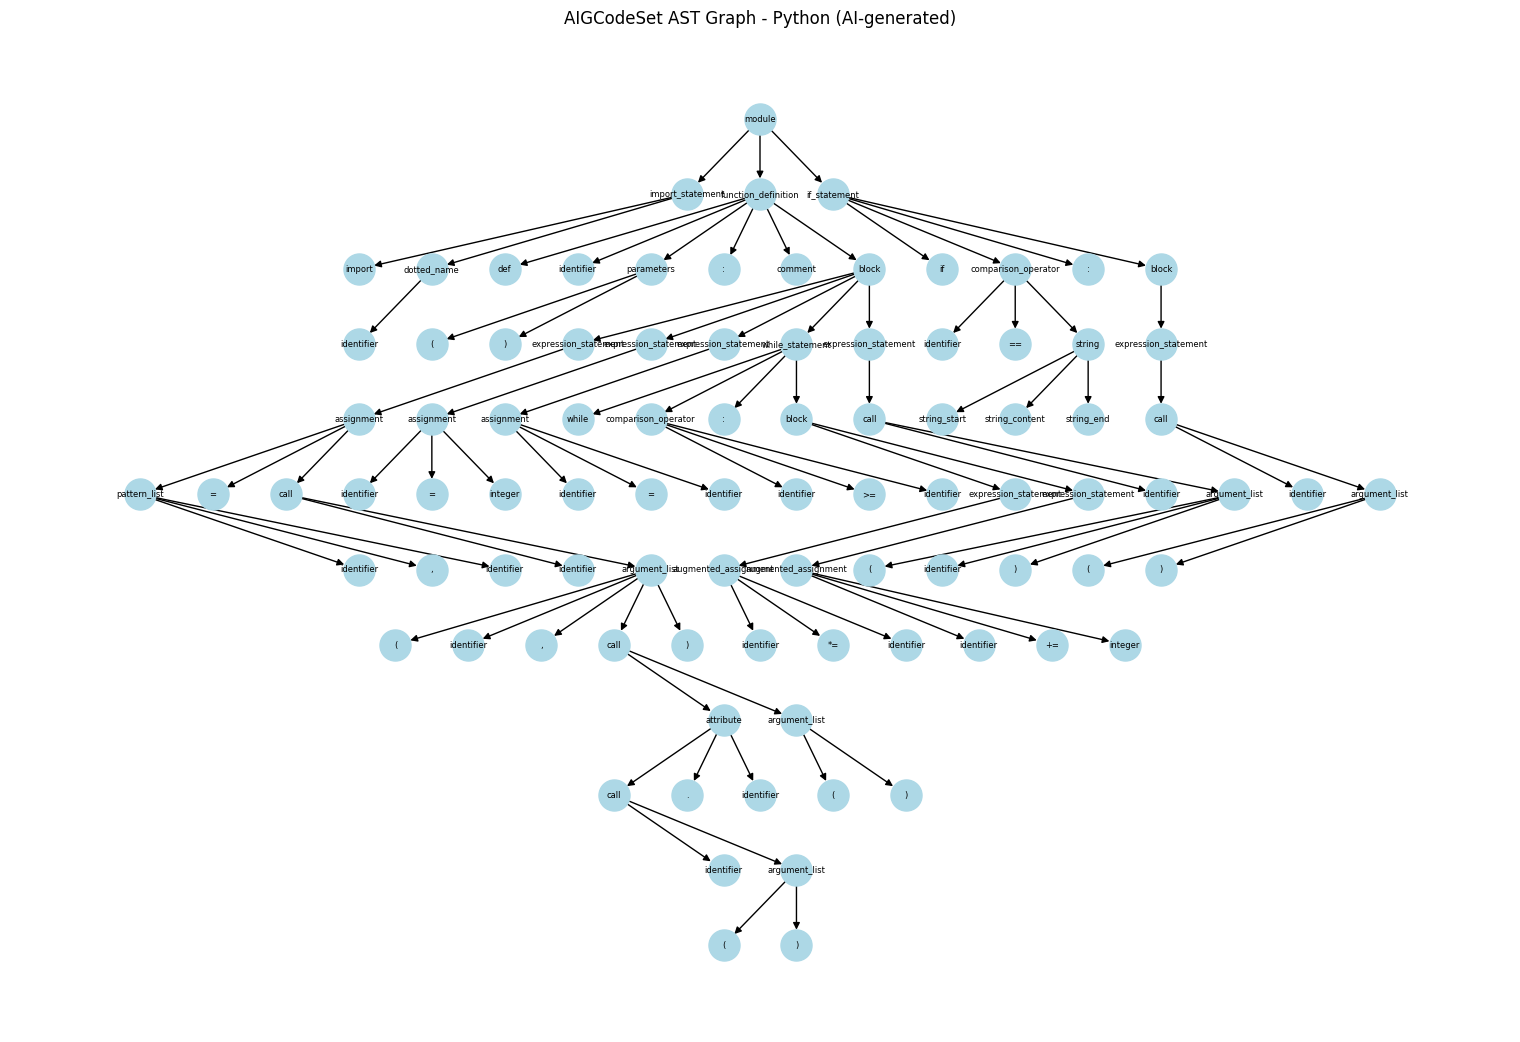

Comparing Human vs AI generated code structures...

Human-generated code example:
Code: # coding: utf-8
# Your code here!
import numpy as np

n = input()
m = input().strip().split()
l = [0] * 100000
k = [0] * 100000
b = m[0::2]
c = m[1::2...


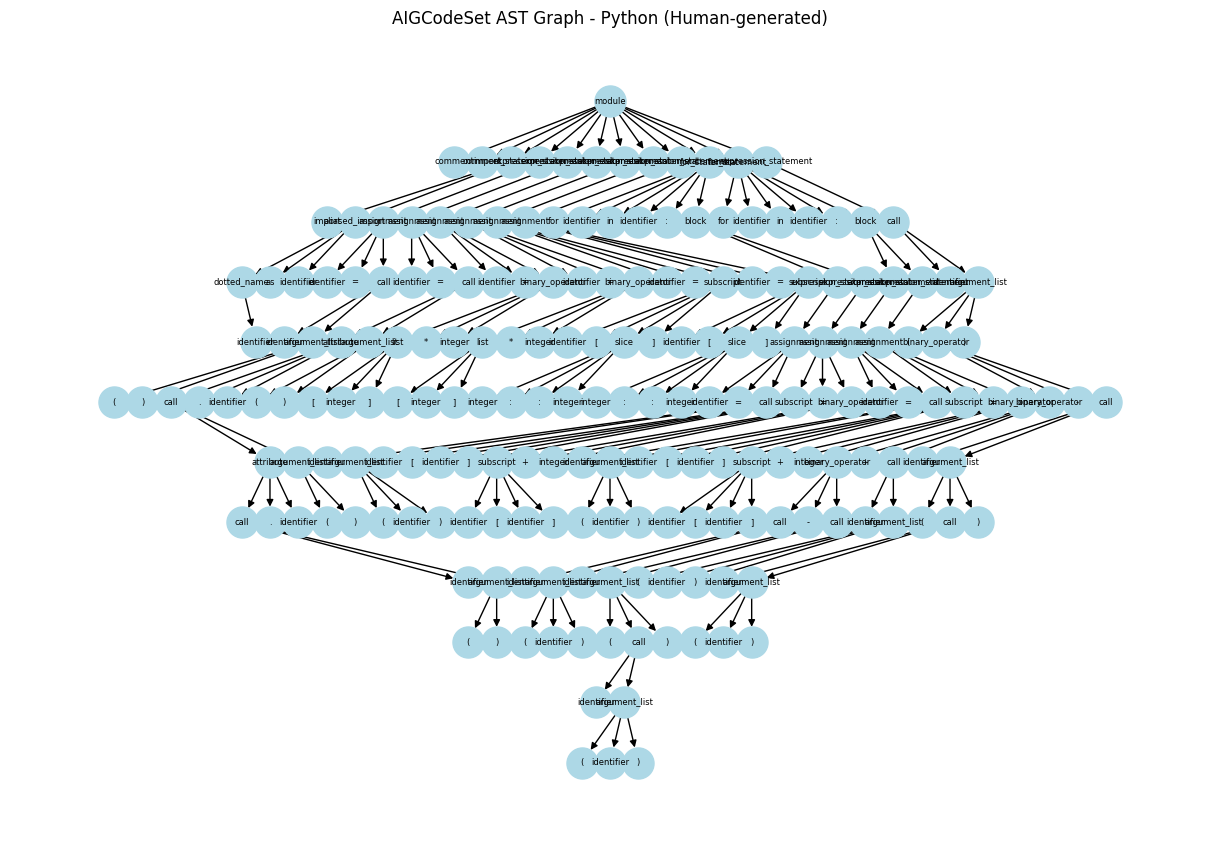


AI-generated code example:
Code: import sys

def main():

    # sys.stdin = open('input156b.txt')

    n, k = map(int, input().split())

    ans = 1
    m = k
    while n >= m:
      ...


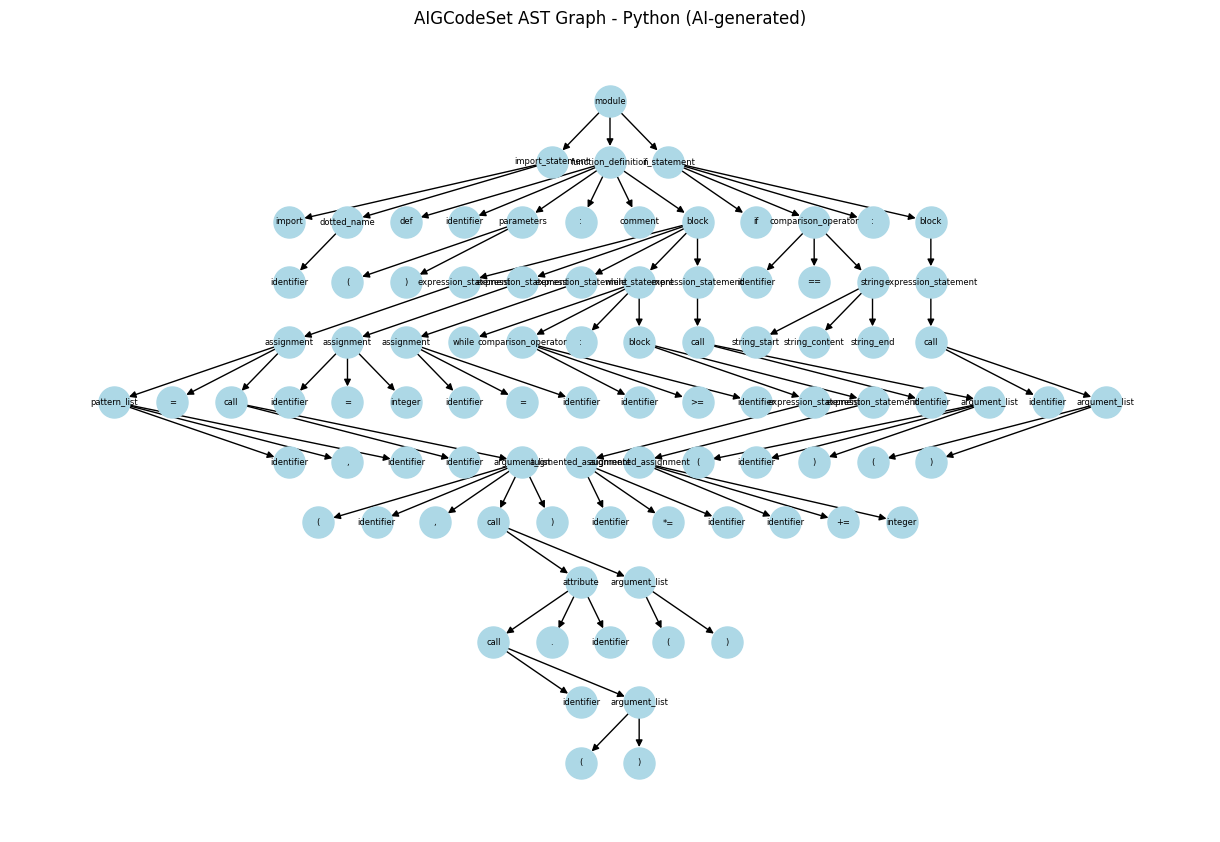


Graph size comparison (first 10 examples):
Human-generated - avg nodes: 341.1, range: 169-926
AI-generated - avg nodes: 188.7, range: 25-702


In [23]:


# Load and inspect the created graphs
from torch import load

train_graphs = load('../../data/aigcodeset_graphs/train_graphs.pt', weights_only=False)
type_to_ind = load('../../data/aigcodeset_graphs/type_to_ind.pt', weights_only=False)

print(f"Loaded {len(train_graphs)} training graphs")
print(f"Sample graph: {train_graphs[0]}")
print(f"Graph metadata: {train_graphs[0].metadata}")


# Visualization function
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    """Visualize AST graph structure"""
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    language = data.metadata.get('language', 'unknown')
    target = 'AI' if data.metadata.get('target', 0) == 1 else 'Human'
    plt.title(f"AIGCodeSet AST Graph - {language.capitalize()} ({target}-generated)")
    plt.show()


# Visualize a sample graph
print("Sample graph visualization:")
print(f"Code: {train_graphs[0].metadata['code'][:200]}...")
print()
visualize_graph(train_graphs[0], show_labels=True)


# Compare Human vs AI generated code graphs
print("Comparing Human vs AI generated code structures...")

# Find examples of each type
human_graphs = [g for g in train_graphs[:50] if g.metadata['target'] == 0]
ai_graphs = [g for g in train_graphs[:50] if g.metadata['target'] == 1]

if human_graphs and ai_graphs:
    print(f"\nHuman-generated code example:")
    print(f"Code: {human_graphs[0].metadata['code'][:150]}...")
    visualize_graph(human_graphs[0], figsize=(12, 8), show_labels=True)
    
    print(f"\nAI-generated code example:")
    print(f"Code: {ai_graphs[0].metadata['code'][:150]}...")
    visualize_graph(ai_graphs[0], figsize=(12, 8), show_labels=True)
    
    # Basic statistics comparison
    human_nodes = [len(g.x) for g in human_graphs[:10]]
    ai_nodes = [len(g.x) for g in ai_graphs[:10]]
    
    print(f"\nGraph size comparison (first 10 examples):")
    print(f"Human-generated - avg nodes: {sum(human_nodes)/len(human_nodes):.1f}, range: {min(human_nodes)}-{max(human_nodes)}")
    print(f"AI-generated - avg nodes: {sum(ai_nodes)/len(ai_nodes):.1f}, range: {min(ai_nodes)}-{max(ai_nodes)}")
else:
    print("Could not find examples of both human and AI generated code in the sample")
